Vehicle velocity model with slope: closed loop model with PI-controller; iterative simulation approach; optimization of controller parameters.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from scipy import constants
from scipy import optimize as opt

In [4]:
def eval_model(model, xs):
    return np.array(list(map(model, xs)))

## Mathematical model

Model of a closed loop system with PI-controller

$\frac{dv(t)}{dt} = \frac{1}{m} [ F_p K_c (v_{SP}(t) - v(t)) + \frac{K_c}{\tau_i} \int e(t) dt - \frac{1}{2} \rho A C_d v(t)^2 ] - g sin(\theta(t))$

In [5]:
# Mass (car + load), kg
m = 700

# Thrust parameter, (N / %pedal)
F_p = 30

# Air density, kg/m^3
rho = 1.225 

# vehicle cross-sectional area (m^2)
A = 5

# Drag coefficient
C_d = 0.24

# Controller gain and integration constant
#K_c = 20.
#tau_i = 12.

def vehicle_model(v, t, setpoint_func, disturbance_func, accumulated_error, K_c, tau_i):
    
    v_sp = setpoint_func(t)
    theta = disturbance_func(t)
        
    drive = F_p * K_c * (v_sp - v) + (K_c / tau_i) * accumulated_error
    drag = 0.5 * rho * A * C_d * (v**2)
    slope = constants.g * np.sin(theta)
    
    return (1. / m) * (drive - drag) - slope
    

## Simulation

In [6]:
t = np.linspace(0, 200, 100)

In [7]:
# setpoint function
def setpoint_strategy(t):
    
    if t < 25:
        return 0
    
    if t >= 25 and t < 100:
        return 10
    
    if t >= 100 and t < 150:
        return 15
    
    if t >= 150:
        return 10
    
# disturbance function   
def no_slope(t):
    return 0

Iterative simulation

In [8]:
def simulate(K_c, tau_i):

    initial = 0.
    v_sim = [initial, ]
    accumulated_error = 0.

    for i in range(len(t) - 1):

        # take t[i] and t[i+1]
        t_pair = t[i:i+2] 
        t_now, t_next = t_pair

        arguments = (setpoint_strategy, no_slope, accumulated_error, K_c, tau_i)
        step_sim = odeint(vehicle_model, initial, t_pair, args=arguments)

        # take the last value
        v_last = step_sim.reshape(-1)[-1]

        # appendt it to the resulting list
        v_sim.append(v_last)

        # save it as initial condition for the next run
        initial = v_last 

        # compute and accumulate error
        error = setpoint_strategy(t_next) - v_last
        error_area_increment = error * (t_next - t_now)
        accumulated_error += error_area_increment

    v_sim = np.array(v_sim).reshape(-1)
    
    return v_sim

In [9]:
# globals: t
def cost_function(params):
    
    K_c, tau_i = params
    
    v_sim = simulate(K_c, tau_i)
    
    error = eval_model(setpoint_strategy, t) - v_sim
    
    sse = np.sum(np.square(error))
    
    return sse

In [10]:
opt_res = opt.minimize(cost_function, x0=[15, 10], bounds=[(5, 25), (5, 25)], method='SLSQP')

In [11]:
opt_res

     fun: 14.46192060793392
     jac: array([42.5133487 , 10.14043427])
 message: 'Optimization terminated successfully'
    nfev: 59
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([23.1588657 , 13.42604843])

In [12]:
K_c, tau_i = opt_res.x

v_sim = simulate(K_c, tau_i)

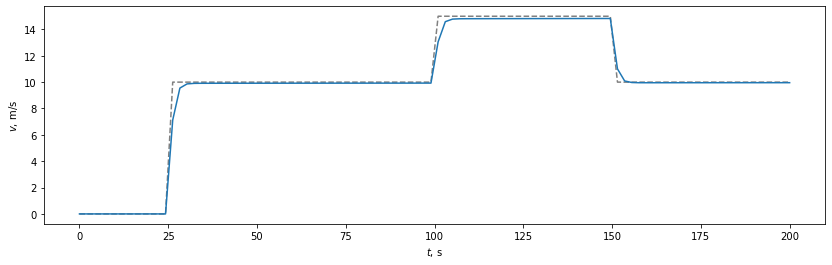

In [13]:
plt.figure(figsize=(14, 4))
plt.plot(t, eval_model(setpoint_strategy, t), '--', color='gray')
plt.plot(t, v_sim)

plt.xlabel('$t$, s')
plt.ylabel('$v$, m/s')
plt.show()

In [14]:
error = eval_model(setpoint_strategy, t) - v_sim

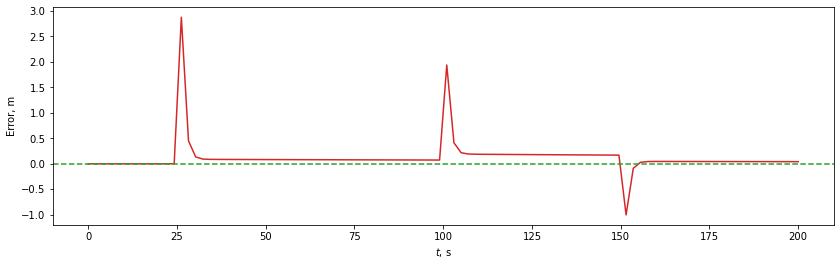

In [15]:
plt.figure(figsize=(14, 4))
plt.plot(t, error, color='tab:red')
plt.axhline(0, linestyle='--', color='tab:green')
plt.xlabel('$t$, s')
plt.ylabel('Error, m')
plt.show()

In [16]:
sse = np.sum(np.square(error))

print('Sum of squared errors during simulation: {:.3f}'.format(sse))

Sum of squared errors during simulation: 14.462
